# DSM150-2022-OCT CW2
<i>Jude Darmanin</i>

---------


In this coursework I will be comparing the performance of different network on a text classification datasets. More specifically, I will attempt to build and tune an LSTM network and test how this more complex network compares to a simple baseline RNN network, as well as to a simple 1D convnet. 

The structure of the following notebook is based on the machine learning workflow outlined in Chollet (2018).

##**Dataset**

The chosen dataset is an e-commerce text classification obtained from Kaggle (https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification).  The datasets consists of two columns, a class name and a text description, for products listed on an e-commerce website. There are multiple classes, so the task at hand is a single-label, multi-class classification problem. The dataset is in csv format.

The below code loads the required modules.

In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
import itertools
import random
from sklearn.utils import compute_class_weight

#NLP modules
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

#Keras and TF modules
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Embedding, SimpleRNN, LSTM, Dropout, Bidirectional, Conv1D

#libraries for the downloading files from Google Drive
from pydrive.auth import GoogleAuth
from google.colab import drive
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


The dataset was downloaded from Kaggle and saved in my personal Google Drive. The below code downloads the dataset from Google Drive into the notebook.

In [ ]:
#helper function
def gdrive_download(id):
  '''
  Function to download files from Google Drive
  id (string) = id of file on Google Drive
  Returns downloaded file.
  '''
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  file_id = id

  #download file
  download = drive.CreateFile({'id': file_id})
  return download

In [ ]:
#downloading data
download_data = gdrive_download('1KoZU3nN001JakVeZuBUFccQRTYe5O0wt') #this file id is specific to the dataset csv stored on personal Google Drive
download_data.GetContentFile('file.csv')
raw_data  = pd.read_csv('file.csv', header=None)

##**Data Overview**

In [ ]:
#viewing the first few rows of the dataset
raw_data.columns = ['Class', 'Description'] #naming columns
raw_data.head()

,Class,Description
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


The raw dataset consists of 2 columns and 50425 samples.

In [ ]:
#viewing dataset shape
raw_data.shape

(50425, 2)

There are four classes, 'Household', 'Books', 'Clothing & Accessories', and 'Electronics'.

In [ ]:
#viewiing unique class labels
raw_data['Class'].unique()

array(['Household', 'Books', 'Clothing & Accessories', 'Electronics'],
      dtype=object)

Luckily the dataset does not contain many missing values. Rows with missing values are dropped.

In [ ]:
print(raw_data.isna().sum()) #print sum of missing values per column
raw_data.dropna(inplace=True) #drop rows with missing values

Class          0
Description    1
dtype: int64


Unfortunately, a large chunk of the dataset is duplicates, which can be expected for data scraped from e-commerce websites. Duplicate rows are dropped from the datasets.

In [ ]:
#drop duplicates
n_duplicates = raw_data['Description'].duplicated().sum() #get sum of duplicate observations
print(f'Dropping {n_duplicates} duplicates')
raw_data.drop_duplicates(inplace = True) #dropping
raw_data.reset_index(drop = True, inplace = True) #resetting index


Dropping 22622 duplicates


Unfortunately, the dataset has shrunk by quite a large amount after dropping duplicates. The cleaned dataset now has 27802 observations.

In [ ]:
#view shape after dropping duplicate rows
raw_data.shape

(27802, 2)

All classes are well represented, though one class does have more observations than others. This would suggest the use of class weighting  in the learning process to prevent the model favouring the majority class.

In [ ]:
#viewing observations per class
raw_data['Class'].value_counts()

Household                 10564
Books                      6256
Clothing & Accessories     5674
Electronics                5308
Name: Class, dtype: int64

##**Text Cleaning**

To aid learning, the text data should be cleaned of any unneccesary noise, such as common stopwords, capitalisation, and punctuation.

In [ ]:
#viewing sample (uncleaned) text
raw_data['Description'][10]

"Painting Mantra 'Vintage Car' Art Printing Set (Synthetic Wood, 60 cm x 50 cm x 2 cm, Brown, Set of 4) Size:60 cm x 50 cm x 2 cm   From the house of art street, we bring this exclusive framed poster to satiate the taste of decor freaks and vintage cars lovers. The filling station-vintage car brown framed poster is a high resolution vintage poster which comes covered in a brown frame. Hang the framed posters depicting image of a car from the nostalgic era on your favourite wall and make it look colourful and vibrant. The product is durable and of high quality. Presented to you with love from art street."

The text is cleaned using traditional NLP technqiues from Python's NLTK library. All text is lower cased and non-alpha characters are removed. Furthermore, frequent English stopwords and words of less than 3 characters are removed, and the text is lemmatized. Lemmatization involes reducing words back to their root form, thus helping the model better recognise similar words.

In [ ]:
#get list of English stopwords
stop_words = stopwords.words("english") 

#get list of english dictionary words
english_words = set(nltk.corpus.words.words())

#initialise lemmatizer
lemmatizer = WordNetLemmatizer()

def text_cleaning(text):
  '''
  Function to clean text via:
  1. lower casing
  2. removal of non-alpha characters
  3. removal of common stopwords
  4. removal of short words
  5. removal of non-English dictionary words
  6. lemmatization

  text is string paramter of text to be cleaned.
  Returns cleaned text
  '''

  #lower case all text
  text = text.lower()

  #remove all non-alpha characters from string, preserving whitespace
  text = re.sub(r'[^a-zA-Z\s]', '', text)

  #remove English stopwords
  text = " ".join([word for word in word_tokenize(text) if word not in stop_words])

  #remove words with less than 3 characters
  text = " ".join([word for word in word_tokenize(text) if len(word) > 2])

  #remove misspelt or non-english words
  text = " ".join([word for word in word_tokenize(text) if word in english_words])

  #lemmatization
  text = " ".join([lemmatizer.lemmatize(word) for word in word_tokenize(text)]) 

  return text

In [ ]:
#applying cleaning and saving in new column
raw_data['Desc_Clean'] = raw_data['Description'].apply(text_cleaning)

In [ ]:
#viewing raw v cleaned sample
original = raw_data['Description'][10]
cleaned = raw_data['Desc_Clean'][10]

print(f'Original Text: \n {original}')
print(f'Cleaned Text: \n {cleaned}')


Original Text: 
 Painting Mantra 'Vintage Car' Art Printing Set (Synthetic Wood, 60 cm x 50 cm x 2 cm, Brown, Set of 4) Size:60 cm x 50 cm x 2 cm   From the house of art street, we bring this exclusive framed poster to satiate the taste of decor freaks and vintage cars lovers. The filling station-vintage car brown framed poster is a high resolution vintage poster which comes covered in a brown frame. Hang the framed posters depicting image of a car from the nostalgic era on your favourite wall and make it look colourful and vibrant. The product is durable and of high quality. Presented to you with love from art street.
Cleaned Text: 
 painting mantra vintage car art printing set synthetic wood brown set size house art street bring exclusive framed poster satiate taste freak vintage car lover filling car brown framed poster high resolution vintage poster come covered brown frame framed poster image car nostalgic era wall make look vibrant product durable high quality love art street


Taking a closer look at the cleaned features, we can see that the mean string length is 57 words. Notice that the minimum is zero, suggesting some empty rows in the cleaned data. These rows are dropped.

In [ ]:
#create new column calculating string length of cleaned text
raw_data['length'] = raw_data['Desc_Clean'].str.split().apply(len)

#describing string length
avg_len = raw_data['length'].mean()
max_len = raw_data['length'].max()
min_len = raw_data['length'].min()

print(f'Average feature length: {avg_len}')
print(f'Lonnets feature: {max_len}')
print(f'Shortest feature: {min_len}')

Average feature length: 57.108085749226674
Lonnets feature: 3872
Shortest feature: 0


In [ ]:
#drop rows with string length less than 3
raw_data = raw_data[raw_data['length'] >= 3]

The total number of unique words (i.e. vocabulary size) in the dataset is just above 20,000. 

In [ ]:
#counting unique tokens
vocab = []
for text in raw_data['Desc_Clean']:
    words = text.split()
    vocab.extend(words)

total_unique_words = len(set(vocab))
print(f'The number of unique tokens is {total_unique_words}')

The number of unique tokens is 21120


##**Preparing Cleaned Text for Network**

To be used as input into a neural network, the text data must be converted into numerical format via encoding or vectorisation.

First, the dataset is split into train and test datasets using a 90-10 ratio.

In [ ]:
#train-test split
def get_dataset_partitions(df, train_split=0.9, test_split=0.1, seed = 10):
    '''
    Function to return dataset split into train and test sets.

    df is original dataframe to be split.
    Returns two split sections of original dataset.
    '''
    assert (train_split + test_split) == 1 #check that test and train split add to 1
    
    df_shuffle = df.sample(frac=1, random_state=seed) #returns back full dataset (frac = 1) but randomly shuffled
    split_point = [int(train_split * len(df))]
    
    train_df, test_df = np.split(df_shuffle, split_point)
    
    return train_df, test_df

#applying split
train_data, test_data = get_dataset_partitions(raw_data) 

The training dataset contains 24485 observations, while the test dataset contains 2721 observations.

In [ ]:
#view split dataset shapes
print(f'Train Data: {train_data.shape}')
print(f'Test Data: {test_data.shape}')

Train Data: (24485, 4)
Test Data: (2721, 4)


Next, the text descriptions are tokenized and vectorised. Vectorisation is done via integer tensors that are padded to ensure all sequences are of same length. This form of vectorisation will allow the data to be passed into an Embedding layer.

For training, I will use a vocabulary size of 5000, which is around 25% of the total vocabulary. Sequences will be trimmed to length 30, which is around half of the mean length.

In [ ]:
vocab_size = 5000 #total number of words to be used (model will use top 'vocab_size' most frequent words)
maxlen = 30 #pad sequence length (use only first 'maxlen' words from each text description) 

def vectorise_text(text_column, num_words = vocab_size, maxlen = maxlen):
  '''
  Function to vectorise and pad/trim text sequences into integer tensors.

  text_column is dataframe column containing text data to be vectorised.
  Returns vectorised sequences and index of words
  '''

  #convert dataframe column to a list
  samples = text_column.to_list()

  #fit the Keras tokenizer on the data, taking into account only the top 'num_words' frequent words
  tokenizer = Tokenizer(num_words=num_words)
  tokenizer.fit_on_texts(samples)
  word_index = tokenizer.word_index #get index of words (used to create embedding matrix)

  #vectorise tokens into integer tensors, which can be passed on to an Embedding layer.
  sequences = tokenizer.texts_to_sequences(samples) 
  
  #pad or trim sequences to make all sequences the same 'maxlen' length 
  padded = preprocessing.sequence.pad_sequences(sequences, maxlen=maxlen)

  return padded, word_index

#apply vectorisation to train and test data
X_train, words_train = vectorise_text(train_data['Desc_Clean'])
X_test, word_test = vectorise_text(test_data['Desc_Clean'])

In [ ]:
#view vectorised data
X_train[10]

array([ 157, 1642,  157,  207, 3200, 2001,  559,  619,  157,   29,  124,
       1186, 2429,  186,  328, 1160,   99,  124,  263, 1489,  103, 1351,
        218, 1501,  759,  246,  124,  619,  559, 1383], dtype=int32)

Apart from the features, the class labels also need to be converted to numerical format. This is done by categorically encoding the class labels.

In [ ]:
#categorise class labels
def label_encoder(class_column):
  '''
  Function to categorise the class labels

  class_column is dataframe column containing categorical class labels
  Returns encoded class labels
  '''
  encoder = LabelEncoder() #initialise Keras label encoder
  labels = encoder.fit_transform(class_column) #fit on text labels

  return labels

#appling class label encoded to train and test datasets
y_train, y_test = label_encoder(train_data['Class']), label_encoder(test_data['Class'])

There are four numerical class labels, which matches the amount of text labels.

In [ ]:
#verifying that all classes are well represented in the test set
unique, counts = np.unique(y_test, return_counts=True)
print(unique, counts)

[0 1 2 3] [ 596  559  493 1073]


##**Additional Prep**

Before training the networks, I perform some additional prep.

First I set up a helper function for plotting training and validation metrics against the number of epochs (to assess overfitting). 

In [ ]:
#helper plotting function
def plot_loss_epochs(model_metrics):
  '''
  Function to plot validation/training loss/accuaracy against number of epochs.

  model_metrics is dictionary containg model training history metrics
  '''
  #get metrics
  acc = model_metrics.history['sparse_categorical_accuracy']
  val_acc = model_metrics.history['val_sparse_categorical_accuracy']
  loss = model_metrics.history['loss']
  val_loss = model_metrics.history['val_loss']

  #calculate number of epochs using length of metrics list
  epochs = range(1, len(acc) + 1)

  #format accuracy plot
  plt.plot(epochs, acc, 'bo', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  #format loss plot
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

I also download the Glove embeddings and set up an embedding matrix to be used as the Embedding layer weights in the networks. Glove Embeddings were developed at Stanford University and are a form of word embedding that emap words into a meaningful space where the distance between words is related to semantic similarity. The embeddings were trained on a corpus of aggregated global word-word co-occurrence statistics.

For this coursework I use the 100 dimensional Glove embeddings. These are downloaded onto Google drive and read into the notebook using the gdrive_download function defined above.

In [ ]:
#downloading Glove embeddings from Google Drive (downloaded from https://nlp.stanford.edu/projects/glove/) 
download_glove = gdrive_download('1LzUGGi06oeyF8IvSmT227kN5gzTuMN01') #this file id is specific to the dataset csv stored on personal Google Drive
download_glove.GetContentFile('glove.6B.100d.txt')

#parse embeddings
embeddings_index = {} #dictionary to store word-embedding pairs
f = open('glove.6B.100d.txt') #open downloaded file
for line in f:
    values = line.split() #each line contains embeddings for 1 word
    word = values[0] #word is first item in line
    coefs = np.asarray(values[1:], dtype='float32') #remaining items in line are embeddings
    embeddings_index[word] = coefs #store in dictionary as word : embeddings array
f.close()

print('Found %s word vectors.' % len(embeddings_index))

#initialise embedding matrix of shape (max_words, embedding_dim) ready to load into an Embedding layer
embedding_dim = 100 #dimension of downloaded embeddings
max_words = vocab_size #max_words used in embedding matrix is limited to our defined vocabulary size
embedding_matrix = np.zeros((max_words, embedding_dim))

#populate embedding matrix with Embedding weights to pass onto Embedding layer, using the words in the word index from the training set
for word, i in words_train.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words: 
        if embedding_vector is not None:
            #words not found in Glove embeddings will be given zero weights
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


##**Baseline**

The below code sets up the baseline network.

A baseline is a simple model against which to compare the more complex network. Since this is text-based data, the baseline will be a simple RNN, using the Glove embeddings to represent the text data. RNNs contain a recurrent layer that processes sequential data by maintaining a hidden state that is updated at each time step. This enables the network to capture temporal dependencies in the data.

In [ ]:
#set up RNN
rnn_model = Sequential()
rnn_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(4, activation='softmax')) #classifier (output four class probabilities)
rnn_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['sparse_categorical_accuracy'])
#use sparse_categorical_crossentropy as loss since y labels are encoded as integers (not one hot)

#set the Embedding layer weights to be non-trainable and frozen at the Glove embeddings
rnn_model.layers[0].set_weights([embedding_matrix])
rnn_model.layers[0].trainable = False

rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 100)           500000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 4)                 132       
                                                                 
Total params: 504,388
Trainable params: 4,388
Non-trainable params: 500,000
_________________________________________________________________


The RNN gives a modest accruacy score of just above 39% on the test set. This is a 4-class classification tastk, meaning a random guess would achieve 25% accuracy. Hence, although modest, the RNN performs better than a random guess, suggesting that some learning is occurring.

86/86 [==============================] - 0s 5ms/step - loss: 2.2569 - sparse_categorical_accuracy: 0.3921


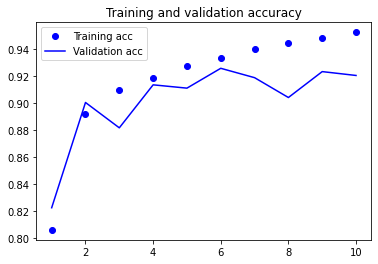

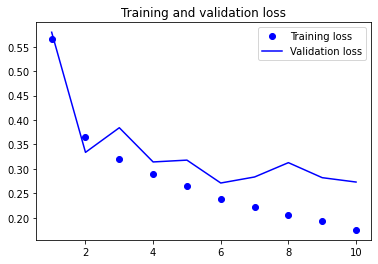

In [ ]:
#fit the model
rnn_train = rnn_model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.10, 
                    verbose = 0)

#evaluate on test set
rnn_model.evaluate(X_test, y_test)
#plot validation scores against epochs
plot_loss_epochs(rnn_train)

##**LSTM Model**

Now that the baseline model has been trained and evaluated, I will attempt to build a more complex LSTM network that outperforms the baseline. LSTMs are commonly used for processing sequential data as they are able to learn long-term dependencies between time steps in the sequence, and hence are more powerful than simple RNNs.

I start with a simple, 1-layer LSTM:

In [ ]:
#set up LSTM
lstm_model = Sequential()
lstm_model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
lstm_model.add(LSTM(32))
lstm_model.add(Dense(4, activation='softmax'))

#set the first layer's (embedding layer) weights to glove embeddings and don't allow training
lstm_model.layers[0].set_weights([embedding_matrix])
lstm_model.layers[0].trainable = False

lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 100)           500000    
                                                                 
 lstm_2 (LSTM)               (None, 32)                17024     
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 517,156
Trainable params: 17,156
Non-trainable params: 500,000
_________________________________________________________________


The simple LSTM performs better than the baseline, achieving an accuracy of just above 35% - this is better than a random guess but not as good as the baseline RNN. 

However, there is some evidence of overfitting in the plots, starting at epoch 8 when the validation performance improvement stalls. Hence, some steps will be taken to reduce overfitting. Overfitting is caused by the trained network learning the intricacies of the training data too well, thus being unable to generalise to unseen data.

86/86 [==============================] - 0s 3ms/step - loss: 2.3446 - sparse_categorical_accuracy: 0.3558


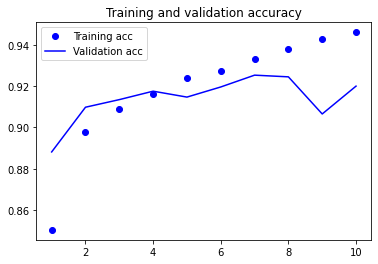

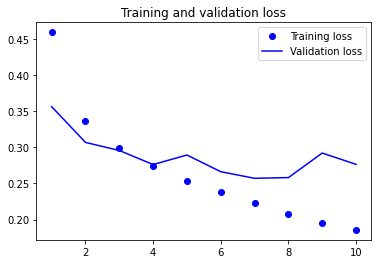

In [ ]:
#compile
lstm_model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

#fitting
lstm_train = lstm_model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.10,
                    verbose = 0)

#evaluate
lstm_model.evaluate(X_test, y_test)

#plot validation scores against epochs
plot_loss_epochs(lstm_train)

##**Reducing Overfitting**

The LSTM clearly is overfitting, as shown in the plots. Before reducing the number of epochs, I will first try some techniques to reduce overfitting. 

First, I apply class weights to the training process, since the dataset is slightly imbalanced in favour of a major class.

In [ ]:
#compute class weights using Keras compute_class_weight function
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )

#store class weights in dictionary
class_weights = dict(zip(np.unique(y_train), list(class_weights)))
class_weights #view class weights

{0: 1.178296438883542,
 1: 1.2116488519398259,
 2: 1.2803283831834344,
 3: 0.6472718621127207}

Another common technqiue to avoid overfitting is dropout. This consists of randomly dropping out (i.e., setting to zero) some of the neurons in a layer during training, preventing the network from relying too heavily on any one neuron, and encouraging it to learn more robust and generalizable features. 

Dropout can be added to the inputs of the LSTM layer, as well as to the outputs (before passing into the dense classifier). I will start with a small dropout rate of 10%.

In [ ]:
#set up regularised LSTM model
lstm_model_v2 = Sequential()
lstm_model_v2.add(Embedding(max_words, embedding_dim, input_length=maxlen))
lstm_model_v2.add(LSTM(32, dropout = 0.1)) #when using dropout as an argument to the LSTM layer, the dropout is applied to the inputs of the LSTM layer,
lstm_model_v2.add(Dropout(0.1)) #adding a dropout layer after the LSTM layer applies dropout to the outputs of the LSTM layer.
lstm_model_v2.add(Dense(4, activation='softmax'))

lstm_model_v2.layers[0].set_weights([embedding_matrix])
lstm_model_v2.layers[0].trainable = False

lstm_model_v2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 30, 100)           500000    
                                                                 
 lstm_3 (LSTM)               (None, 32)                17024     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 4)                 132       
                                                                 
Total params: 517,156
Trainable params: 17,156
Non-trainable params: 500,000
_________________________________________________________________


Since techniques to reduce overfitting are used, the LSTM is initially trained for more epochs.

The model performances improves (38.3% accuracy) but is still slightly below the baseline. However, the overfitting problem has not been solved; the below validation metric plots suggest that overfitting now starts at 5 epochs.

86/86 [==============================] - 0s 3ms/step - loss: 3.0993 - sparse_categorical_accuracy: 0.3833


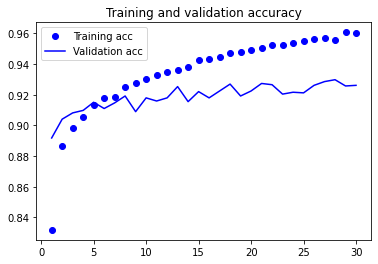

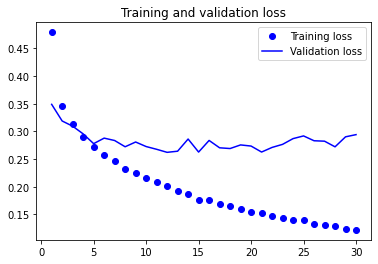

In [ ]:
#compile
lstm_model_v2.compile(optimizer='rmsprop',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

#fitting
lstm_train_v2 = lstm_model_v2.fit(X_train, y_train,
                    epochs=30,
                    batch_size=32,
                    validation_split=0.10, 
                    class_weight=class_weights,
                    verbose = 0)

#evaluate on test set
lstm_model_v2.evaluate(X_test, y_test)

#plot validation scores against epochs
plot_loss_epochs(lstm_train_v2)

To prevent overfitting, I re-train the LSTM using only 5 epochs, along with dropout and class weighting. I will also attempt to use a bidirectional LSTM layer. This layer allows the network to process the data in both forward and backward directions, allowing it to consider future information as well as past data when making predictions.


As can be seen from the below metrics, this does not lead to any improvement; accuracy falls back to 35.9% on the test set. This suggest that the model hyperparameters may need to be tuned.

86/86 [==============================] - 0s 4ms/step - loss: 2.1018 - sparse_categorical_accuracy: 0.3591


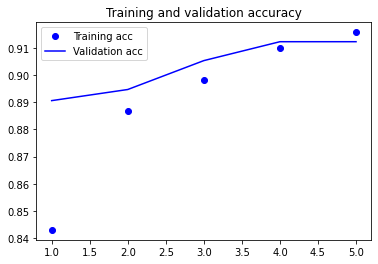

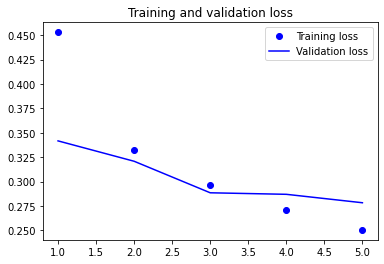

In [ ]:
#set the optimal number of epochs to prevent overfitting
opt_epochs = 5

#setting up
lstm_model_v3 = Sequential()
lstm_model_v3.add(Embedding(max_words, embedding_dim, input_length=maxlen))
lstm_model_v3.add(Bidirectional(LSTM(32, dropout = 0.1))) 
lstm_model_v3.add(Dropout(0.1)) 
lstm_model_v3.add(Dense(4, activation='softmax'))

lstm_model_v3.layers[0].set_weights([embedding_matrix])
lstm_model_v3.layers[0].trainable = False

#compile
lstm_model_v3.compile(optimizer='rmsprop',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

#fit 
lstm_train_v3 = lstm_model_v3.fit(X_train, y_train,
                    epochs=opt_epochs,
                    batch_size=32,
                    validation_split=0.10, 
                    class_weight=class_weights,
                    verbose = 0)

#evaluate
lstm_model_v3.evaluate(X_test, y_test)

#plot
plot_loss_epochs(lstm_train_v3)

##**Hyperparameter Optimisation**

Among the hyperparameters that can be tuned in an LSTM network are the dropout rate, the number of hidden units in the LSTM layers, and the number of layers. To rotate and test different combinations of hyperparameters, I define a function that compiles an LSTM model according to the hyperparameters to be tested.

In [ ]:
def lstm_compile(starting_hidden_units, layers, dropout, max_words=max_words, embedding_dim=embedding_dim, maxlen=maxlen):
  '''
  Function to compile LSTM model.

  starting_hidden_units = hidden units in first LSTM layer
  layers = number of LSTM layers
  dropout = dropout rate
  max_words = vocabulary size
  embedding_dim = dimensions of embedding matrix
  maxlen = length of input sequences

  Returns compiled model object.
  '''
  model = Sequential()
  model.add(Embedding(max_words, embedding_dim, input_length=maxlen))

  #add hidden layers
  for i in range(1, layers+1):
    if i == layers: #if this is the last hidden layer, switch return_sequences to False
      seq_switch = False
    else: 
      seq_switch = True
    model.add(Bidirectional(LSTM(units=starting_hidden_units//i, dropout = dropout, return_sequences=seq_switch)))
      #drop number of hidden units by factor 'i' as more layers are added
  
  model.add(Dropout(dropout)) #add dropout layer before dense classifier
  model.add(Dense(4, activation='softmax'))
  
  #set embedding layer to non-trainable
  model.layers[0].set_weights([embedding_matrix])
  model.layers[0].trainable = False

  model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

  return model


def fit_and_evaluate(model, batch_size, epochs, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, class_weights = class_weights):
  '''
  Function to fit model on data and return accuracy score.

  model = compiled network
  batch_size = size of batches
  epochs = number of epochs to train on

  Returns model accuracy on test set
  '''
  model_train = model.fit(X_train, y_train,
                      epochs=epochs,
                      batch_size=batch_size,
                      validation_split=0.10,
                      class_weight=class_weights,
                      verbose = 0)
  scores = model.evaluate(X_test, y_test, verbose = 0)
  model_accuracy = scores[1]
  return model_accuracy

I create different combinations of the three hyperparameters using itertools:

In [ ]:
d = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5] #dropout rates to test
h = [16, 32, 64, 128, 256, 512] #hidden units to test
l = [1, 2, 3, 4] #number of layers to test

#create different combinations for the different hyperparameter values
candidates = list(itertools.product(d, h, l))
len(candidates)


144

The number of candidate combinations to test is too high given my computing capacity. To perform a fair test, I will using the random tool to randomly select 25 different hyperparameter combinations from this list, which will be tested.

In [ ]:
n = 25  # number of candidates to test
selected_candidates = random.sample(candidates, n)

selected_candidates

[(0.1, 64, 3),
 (0.1, 256, 2),
 (0.5, 16, 3),
 (0.1, 256, 3),
 (0.0, 32, 2),
 (0.4, 64, 2),
 (0.3, 32, 4),
 (0.5, 64, 2),
 (0.2, 32, 4),
 (0.2, 16, 3),
 (0.5, 256, 4),
 (0.5, 16, 4),
 (0.4, 512, 1),
 (0.3, 512, 3),
 (0.0, 64, 4),
 (0.5, 512, 2),
 (0.1, 256, 1),
 (0.2, 32, 3),
 (0.3, 64, 4),
 (0.0, 128, 4),
 (0.1, 32, 3),
 (0.5, 256, 2),
 (0.2, 256, 4),
 (0.4, 16, 4),
 (0.3, 16, 1)]

Now loop through the candidate combinations and record their final accuracy scores:

In [ ]:
candidate_scores = [] #store scores
counter = 0 #model counter

#looping through candidates and storing scores
for (d,h,l) in selected_candidates:
  test_model = lstm_compile(h, l, d) #compile model using hyperparameter values
  print(f'Testing candidate {counter}')
  score = fit_and_evaluate(test_model, 32, opt_epochs) #fit using optimal number of epochs
  candidate_scores.append((counter, score)) #store model accuracy score
  counter += 1

Testing candidate 0
Testing candidate 1
Testing candidate 2
Testing candidate 3
Testing candidate 4
Testing candidate 5
Testing candidate 6
Testing candidate 7
Testing candidate 8
Testing candidate 9
Testing candidate 10
Testing candidate 11
Testing candidate 12
Testing candidate 13
Testing candidate 14
Testing candidate 15
Testing candidate 16
Testing candidate 17
Testing candidate 18
Testing candidate 19
Testing candidate 20
Testing candidate 21
Testing candidate 22
Testing candidate 23
Testing candidate 24


Identifying the model with the best score:

In [ ]:
best_model = sorted(candidate_scores, key=lambda x: x[1], reverse=True)[0] #sort the list in descending order based on the score element
best_counter = best_model[0] #get counter of best model
best_combination = selected_candidates[best_counter] #get hyperparameter combination with best accuracy score
print(f'The best hyperparameter combination is a drouput rate of {best_combination[0]}, {best_combination[1]} hidden units, and {best_combination[2]} layers, giving a score of {best_model[1]}')

The best hyperparameter combination is a drouput rate of 0.5, 512 hidden units, and 2 layers, giving a score of 0.3917677402496338


Th optimal combination of hyperparameters using a BiDirectional LSTM model is a dropout rate of 0.5, 512 hidden units it the first layer (gradually dropping), and 2 layers. 

The accuracy score on this combination is 39.2%, which is the same as the baseline RNN. Hence, despite the additional complexity, this LSTM does not perform better than the baseline model.  

##**1D Convnet**

As a final test, I check whether a 1D convnet can outperform the tuned LSTM and the baseline RNN. a 1D convolutional layer applies a set of filters to the input sequence, which slide windows or kernels over the input and produces a set of feature maps. Each feature map represents a particular feature or pattern in the input sequence.


I use an arbitrary kernel size of 5 and 16 filters. Thus, each window in the convolutional layer sees 5 tokens.

In [ ]:
#setting up the 1D convnet
model_conv = Sequential()
model_conv.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model_conv.add(Conv1D(filters = 16, kernel_size = 5))
model_conv.add(Flatten())
model_conv.add(Dropout(0.5))
model_conv.add(Dense(4, activation='softmax'))

model_conv.layers[0].set_weights([embedding_matrix])
model_conv.layers[0].trainable = False

#compile
model_conv.compile(optimizer='rmsprop',
            loss='sparse_categorical_crossentropy',
            metrics=['sparse_categorical_accuracy'])

#fit and evaluate
model_conv_train = model_conv.fit(X_train, y_train,
                    epochs=opt_epochs,
                    batch_size=32,
                    validation_split=0.10, 
                    class_weight=class_weights,
                    verbose = 0)

#evaluate
model_conv.evaluate(X_test, y_test)

86/86 [==============================] - 0s 4ms/step - loss: 2.0323 - sparse_categorical_accuracy: 0.3355


[2.0322842597961426, 0.33553841710090637]

The 1D convnet performs worse than the baseline and the tuned LSTM, giving an accuracy of only 33.6%. However, the convnet hasn't been tuned, as with the LSTM, so this is quite a decent performance. Improvements could be made, such as by adding layers, filters, or changing the kernel size.

##**Conclusion**

In this coursework I attempted a single-label, multi-class classification problem using deep learning.  I trained and tuned an LSTM model using a combination of hyperparameters for the dropout rate, the number of hidden units, and the number of layers. Despite this tuning and additional complexity, the resulting model performed only as good as the simple RNN baseline model. A 1D convnet was also tested (though not tuned), and performed worse than both models. 

Naturally, there are a number of further improvements that could be made to the LSTM model. There are other hyperparameters which could be tuned, such as the learning rate, batch size, and the number of dense layers. Due to computation limitations, I was unable to test more hyperparameter combinations.

Furthermore, one could test different vocabulary and sequence sizes, as different input versions may have an effect on the model. The text data could be cleaned further, such as by removing words that appear in a large majority of the samples. Finally, the training data could be improved through methods such as data augmentation, or by using different word embeddings.

### **<u>References</u>**

#### **Websites**
https://www.kaggle.com/datasets/saurabhshahane/ecommerce-text-classification

https://nlp.stanford.edu/projects/glove/

https://www.kaggle.com/code/sugataghosh/e-commerce-text-classification-tf-idf-word2vec#TF-IDF-Model

https://www.kaggle.com/code/naifislam/ecommerce-text-classification-bert

https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438

#### **Other Material**
Chollet, F (2018). *Deep Learning with Python*. Manning Publications Co. ISBN 9781617294433

Neural Networks (DSM150-2022-OCT) - lectures & notebooks. University of London.